In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import coiled
import dask
import xarray as xr
import xclim

from ocr.risks.fire import classify_wind_directions, direction_histogram, nws_fire_weather
from ocr.utils import load_conus404

In [3]:
args = {
    'name': 'fire-weather-distribution',
    'region': 'us-west-2',
    'n_workers': [2, 30],
    'tags': {'Project': 'OCR'},
    'worker_vm_types': 'm8g.8xlarge',
    'scheduler_vm_types': 'm8g.2xlarge',
}
cluster = coiled.Cluster(**args)
client = cluster.get_client()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│                ╷                                                             │
│   Package      │ Note                                                        │
│ ╶──────────────┼───────────────────────────────────────────────────────────╴ │
│   ocr          │ Wheel built from ~/devel/carbonplan/ocr                     │
│                ╵                                                             │
╰──────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────── Not Synced with Cluster ───────────────────────────╮
│           ╷                                                      ╷           │
│   Package │ Error                                                │ Level     │
│ ╶─────────┼──────────────────────────────────────────────────────┼─────────╴ │
│   s5cmd   │ s5cmd~=2.3.0 has no install candidate for Python     │ Warning   │
│           │ 3.13 linux-aarch64 on conda-forge                    │           │
│           ╵                                                      ╵           │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

2025-08-07 11:46:52,748 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=2 maximum=30


In [4]:
# Make relative humidity intermediate data variable

In [5]:
ds = load_conus404()
ds

<xarray.Dataset> Size: 13TB
Dimensions:  (time: 376945, y: 1015, x: 1367)
Coordinates:
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
  * time     (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
Data variables:
    PSFC     (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    Q2       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    T2       (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    TD2      (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    U10      (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
    V10      (time, y, x) float32 2TB dask.array<chunksize=(376945, 10, 10), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [6]:
%%time
recreate_rh = False
if recreate_rh:
    hurs = xclim.indicators.atmos.relative_humidity_from_dewpoint(tas=ds['T2'], tdps=ds['TD2'])
    hurs = dask.optimize(hurs)[0]
    hurs.to_zarr(
        's3://carbonplan-ocr/intermediate/met-data/conus404/hurs.zarr',
        consolidated=True,
        mode='w',
    )

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.1 μs


In [7]:
# Make sfcWindspeed and sfcWindfromdir intermediate variables

In [8]:
%%time
recreate_winds = False
if recreate_winds:
    winds = xclim.indicators.atmos.wind_speed_from_vector(uas=ds['U10'], vas=ds['V10'])[
        0
    ].to_dataset()
    winds['sfcWindfromdir'] = xclim.indicators.atmos.wind_speed_from_vector(
        uas=ds['U10'], vas=ds['V10']
    )[1]
    winds = dask.optimize(winds)[0]
    winds.to_zarr(
        's3://carbonplan-ocr/intermediate/met-data/conus404/winds.zarr',
        consolidated=True,
        mode='w',
    )

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 2.86 μs


In [9]:
# calculate whether there is fire weather

In [10]:
hurs = xr.open_zarr('s3://carbonplan-ocr/intermediate/met-data/conus404/hurs.zarr')
wind = xr.open_zarr('s3://carbonplan-ocr/intermediate/met-data/conus404/winds.zarr')
fire_weather_mask = nws_fire_weather(
    hurs['hurs'],
    15,
    # reason that wind gusts are typically ~40% higher than average wind speed
    # and we want to base this on wind gusts (need a citation for this)
    wind['sfcWind'] * 1.4,
    35,
)

fire_weather_mask = dask.optimize(fire_weather_mask)[0]

In [24]:
%%time
recreate_direction_indices = False
if recreate_direction_indices:
    direction_indices = classify_wind_directions(wind['sfcWindfromdir'])
    direction_indices.to_zarr(
        's3://carbonplan-ocr/intermediate/met-data/conus404/winds-direction-indices.zarr',
        consolidated=True,
        mode='w',
    )

direction_indices = xr.open_zarr(
    's3://carbonplan-ocr/intermediate/met-data/conus404/winds-direction-indices.zarr'
)['wind_direction_classification']

direction_indices

CPU times: user 84.1 ms, sys: 33.5 ms, total: 118 ms
Wall time: 898 ms


<xarray.DataArray 'wind_direction_classification' (time: 376945, y: 1015,
                                                   x: 1367)> Size: 2TB
dask.array<open_dataset-wind_direction_classification, shape=(376945, 1015, 1367), dtype=float32, chunksize=(376945, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
Attributes:
    long_name:         wind direction classified into 8 cardinal directions (...
    short_name:        wind_direction_classification
    direction_labels:  ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

In [26]:
%%time

# we are going to reuse this. we should save it to a zarr store
# then we can apply the fire_weather_mask dynamically.
masked_direction_indices = direction_indices.where(fire_weather_mask)

# create the distribution of winds based upon the classified wind directions
# if there are nans in the mix, they won't contribute to the distribution
fraction = direction_histogram(masked_direction_indices)
fraction = dask.optimize(fraction)[0]
fraction

CPU times: user 2 s, sys: 184 ms, total: 2.18 s
Wall time: 2.19 s


<xarray.DataArray 'wind_direction_histogram' (y: 1015, x: 1367,
                                              wind_direction: 8)> Size: 44MB
dask.array<transpose, shape=(1015, 1367, 8), dtype=float32, chunksize=(10, 10, 8), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 8kB -2.028e+06 -2.024e+06 ... 2.024e+06 2.028e+06
  * x        (x) float64 11kB -2.732e+06 -2.728e+06 ... 2.728e+06 2.732e+06
Dimensions without coordinates: wind_direction
Attributes:
    long_name:  Wind Direction Histogram
    units:      probability

In [27]:
fraction.isel(x=0, y=0).compute()

/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 12.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.DataArray 'wind_direction_histogram' (wind_direction: 8)> Size: 32B
array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
    y        float64 8B -2.028e+06
    x        float64 8B -2.732e+06
Dimensions without coordinates: wind_direction
Attributes:
    long_name:  Wind Direction Histogram
    units:      probability

In [28]:
%%time
fraction.to_zarr(
    's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_distribution-hurs15_wind35.zarr',
    mode='w',
    consolidated=True,
)

/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/zarr/api/asynchronous.py:229: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 12.49 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3.69 s, sys: 473 ms, total: 4.17 s
Wall time: 7min 39s


In [32]:
%%time
fraction = xr.open_zarr(
    's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_distribution-hurs15_wind35.zarr'
)['wind_direction_histogram']
# sum up the fractions of all of the wind directions. if any pixel sums to zero it will
# fall into the no_fire_weather mask and be cast to a `nan`. if any pixel has any fraction
# of timestamps with fire weather then it will be cast into the mask where there *is* fire weather
no_fire_weather = fraction.sum(dim='wind_direction')
mode = fraction.argmax(dim='wind_direction').where(no_fire_weather).chunk({'x': -1, 'y': -1})


mode.to_zarr(
    's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_mode-hurs15_wind35.zarr',
    mode='w',
    consolidated=True,
)

/Users/andersy005/devel/carbonplan/ocr/.pixi/envs/default/lib/python3.13/site-packages/zarr/api/asynchronous.py:229: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


CPU times: user 480 ms, sys: 62.5 ms, total: 542 ms
Wall time: 30.9 s


In [33]:
test = xr.open_zarr(
    's3://carbonplan-ocr/intermediate/met-data/conus404/fire_weather_wind_mode-hurs15_wind35.zarr'
)

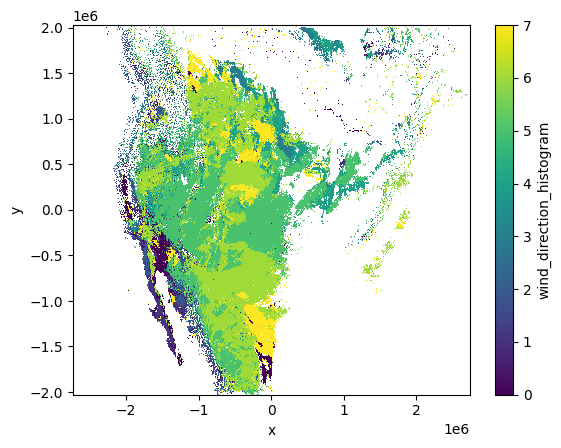

In [35]:
test.wind_direction_histogram.plot()

In [ ]:
cluster.close()